Training PINN...
Epoch 0, Loss: 343.871521
Epoch 1000, Loss: 149.090820
Epoch 2000, Loss: 135.048737
Epoch 3000, Loss: 117.861893
Epoch 4000, Loss: 110.698433
Epoch 5000, Loss: 94.319572
Epoch 6000, Loss: 89.140594
Epoch 7000, Loss: 82.095421
Epoch 8000, Loss: 75.120499
Epoch 9000, Loss: 70.952255


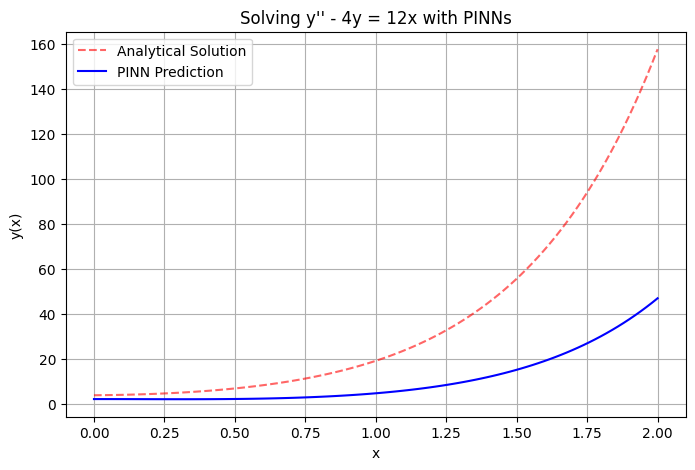

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the forcing term f(x) = 12x
def forcing_function(x):
    return 12.0 * x

# PINN neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# 2. Physics-Informed Loss for: y'' - 4y = 12x
def physics_loss(model, x):
    x.requires_grad = True
    y = model(x)

    # Compute y'
    y_x = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    # Compute y''
    y_xx = torch.autograd.grad(y_x, x, torch.ones_like(y_x), create_graph=True)[0]

    # Residual: y'' - 4y - 12x = 0
    f = forcing_function(x)
    physics_residual = y_xx - 4.0 * y - f

    return torch.mean(physics_residual**2)

# 3. Initial Condition Loss for: y(0)=4 and y'(0)=1
def initial_condition_loss(model):
    x_0 = torch.tensor([[0.0]], requires_grad=True)
    y_0 = model(x_0)

    # Compute y'(0)
    y_x = torch.autograd.grad(y_0, x_0, torch.ones_like(y_0), create_graph=True)[0]

    # y(0) = 4 loss
    loss_y0 = (y_0 - 4.0)**2
    # y'(0) = 1 loss
    loss_dy0 = (y_x - 1.0)**2

    return loss_y0 + loss_dy0

# Training Function
def train_pinn(model, optimizer, epochs=10000):
    for epoch in range(epochs):
        # Sample x in the domain [0, 2]
        x = torch.rand(256, 1) * 2.0

        p_loss = physics_loss(model, x)
        ic_loss = initial_condition_loss(model)

        # Total loss (Weighting the IC loss higher can help convergence)
        loss = p_loss + 10.0 * ic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

if __name__ == "__main__":
    pinn_model = PINN()
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.001)

    print("Training PINN...")
    train_pinn(pinn_model, optimizer)

    # Comparison with Analytical Solution: y(x) = 3e^{2x} + e^{-2x} - 3x
    x_test = torch.linspace(0, 2, 100).reshape(-1, 1)
    y_pred = pinn_model(x_test).detach().numpy()

    x_np = x_test.numpy()
    y_true = 3*np.exp(2*x_np) + np.exp(-2*x_np) - 3*x_np

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(x_np, y_true, 'r--', label="Analytical Solution", alpha=0.6)
    plt.plot(x_np, y_pred, 'b-', label="PINN Prediction")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solving y'' - 4y = 12x with PINNs")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch    0 | Total: 2.201502e+02 | Physics: 5.899664e+01 | IC: 1.611536e+01
Epoch  500 | Total: 7.119725e+01 | Physics: 2.335018e+01 | IC: 4.784707e+00
Epoch 1000 | Total: 2.187459e+01 | Physics: 6.638431e+00 | IC: 1.523616e+00
Epoch 1500 | Total: 8.640027e+00 | Physics: 4.022491e+00 | IC: 4.617536e-01
Epoch 2000 | Total: 2.223014e+00 | Physics: 8.995931e-01 | IC: 1.323421e-01
Epoch 2500 | Total: 1.572422e+00 | Physics: 8.448170e-01 | IC: 7.276047e-02
Epoch 3000 | Total: 5.465589e-02 | Physics: 3.125612e-02 | IC: 2.339977e-03
Epoch 3500 | Total: 8.407601e-02 | Physics: 8.103502e-02 | IC: 3.040992e-04
Epoch 4000 | Total: 2.149083e-02 | Physics: 2.066054e-02 | IC: 8.302874e-05
Epoch 4500 | Total: 1.305692e-02 | Physics: 1.228438e-02 | IC: 7.725353e-05


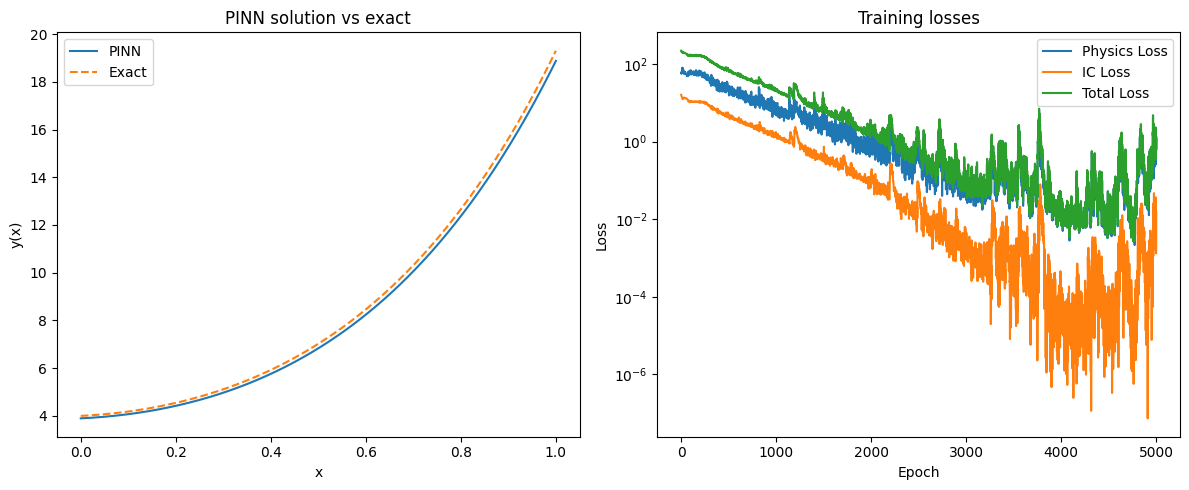

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ODE: y'' - 4y = 12x,  with y(0)=4, y'(0)=1

def forcing_function(x):
    return 12.0 * x

# Exact solution (for comparison): y = 3e^{2x} + e^{-2x} - 3x
def exact_solution(x):
    return 3.0 * np.exp(2.0 * x) + np.exp(-2.0 * x) - 3.0 * x

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.layers(x)

def physics_loss(model, x):
    x = x.clone().detach().requires_grad_(True)
    y = model(x)

    y_x = torch.autograd.grad(
        y, x, torch.ones_like(y), create_graph=True
    )[0]

    y_xx = torch.autograd.grad(
        y_x, x, torch.ones_like(y_x), create_graph=True
    )[0]

    residual = y_xx - 4.0 * y - forcing_function(x)
    return torch.mean(residual**2)

def initial_condition_loss(model):
    x0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    y0 = model(x0)
    y0_x = torch.autograd.grad(
        y0, x0, torch.ones_like(y0), create_graph=True
    )[0]

    loss_y0 = (y0 - 4.0) ** 2
    loss_dy0 = (y0_x - 1.0) ** 2
    return torch.mean(loss_y0 + loss_dy0)

def train_pinn(model, optimizer, epochs=6000, num_train_points=256, x_min=0.0, x_max=1.0, w_ic=10.0):
    p_losses, ic_losses, total_losses = [], [], []

    for epoch in range(epochs):
        x = (x_max - x_min) * torch.rand(num_train_points, 1) + x_min

        p_loss = physics_loss(model, x)
        ic_loss = initial_condition_loss(model)
        loss = p_loss + w_ic * ic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        p_losses.append(p_loss.item())
        ic_losses.append(ic_loss.item())
        total_losses.append(loss.item())

        if epoch % 500 == 0:
            print(
                f"Epoch {epoch:4d} | Total: {loss.item():.6e} | Physics: {p_loss.item():.6e} | IC: {ic_loss.item():.6e}"
            )

    return p_losses, ic_losses, total_losses

if __name__ == "__main__":
    torch.manual_seed(0)
    np.random.seed(0)

    pinn = PINN()
    optimizer = torch.optim.Adam(pinn.parameters(), lr=5e-4)

    # Domain for training (change x_max if you want a wider interval)
    x_min, x_max = 0.0, 1.0

    p_losses, ic_losses, total_losses = train_pinn(
        pinn, optimizer, epochs=5000, num_train_points=256, x_min=x_min, x_max=x_max, w_ic=10.0
    )

    # Test + compare to exact
    x_test = torch.linspace(x_min, x_max, 300).reshape(-1, 1)
    y_pred = pinn(x_test).detach().cpu().numpy().reshape(-1)

    x_np = x_test.detach().cpu().numpy().reshape(-1)
    y_true = exact_solution(x_np)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_np, y_pred, label="PINN")
    plt.plot(x_np, y_true, label="Exact", linestyle="--")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("PINN solution vs exact")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(p_losses, label="Physics Loss")
    plt.plot(ic_losses, label="IC Loss")
    plt.plot(total_losses, label="Total Loss")
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training losses")
    plt.legend()

    plt.tight_layout()
    plt.show()